### 准备数据

$y_{i} = 2 * X_{[i][0]} - 3.4 * X_{[i][1]} + 4.2 + noise$

$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$

首先，准备输入数据

In [2]:
import numpy as np

#num_inputs:特征维度
num_inputs = 2
#num_examples:样本个数
num_examples = 1000

true_w = np.array([2, -3.4]).T
true_b = 4.2

X = np.random.normal(0, 1, size=(num_examples, num_inputs))
print X
y = np.matmul(X, true_w) + true_b
y += .01 * np.random.normal(0, 1, size=y.shape)
print y.shape

[[ 1.6145403  -0.96859078]
 [-1.12309537 -0.37416874]
 [ 1.25166272 -2.92086875]
 ...
 [-0.15488276  0.96248845]
 [-0.80305875  1.46749978]
 [ 0.29975952 -2.05400354]]
(1000,)


如果有兴趣，可以使用安装包中已包括的 Python 绘图包 matplotlib，生成第二个特征值 ``(X[:, 1])`` 和目标值 Y 的散点图，更直观地观察两者间的关系。

In [1]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1], y)
plt.show()

NameError: name 'X' is not defined

### 数据读取
当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回batch_size个随机的样本和对应的目标。我们通过python的yield来构造一个迭代器。

In [3]:
import random
def data_iter(batch_size, num_epochs):
    # 产生一个随机索引
    idx = list(range(num_examples*num_epochs))
    random.shuffle(idx)
    batch_X = []
    batch_y = []
    for i in idx:
        i %= num_examples
        batch_X.append(X[i])
        batch_y.append(y[i])
        if len(batch_X) == batch_size:
            yield np.array(batch_X), np.array(batch_y)
            batch_X = []
            batch_y = []

下面代码读取第一个随机数据块

In [4]:
for data, label in data_iter(1, 1):
    print(data, label)
    print data.shape
    print label.shape
    break

(array([[ 0.42529952, -0.23210211]]), array([5.83504344]))
(1, 2)
(1,)


### 初始化模型参数
下面我们随机初始化模型参数

In [5]:
#目的是通过X和y来拟合参数(w, b)
import tensorflow as tf
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    #initial = tf.truncated_normal(shape, stddev=0.1)
    with tf.name_scope('weights'):
        initial = tf.random_normal_initializer(mean=0.0, stddev=1.0, seed=None, dtype=tf.float32)
#    initial =  tf.zeros_initializer(dtype=tf.float32)
    return tf.Variable(initial(shape))

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    with tf.name_scope('bias'):
        initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### 定义模型
线性模型就是将输入和模型的权重（w）相乘，再加上偏移（b）：



In [6]:
def net(input_tensor, input_dim, output_dim):
    weights = weight_variable((input_dim, output_dim))
    bias = bias_variable([output_dim])
    return tf.matmul(input_tensor, weights) + bias, weights, bias

### 损失函数
我们使用常见的平方误差来衡量预测目标和真实目标之间的差距。

In [7]:
def loss(predict, gt_tensor):
    #return tf.losses.mean_squared_error(tf.squeeze(predict), gt_tensor)
    return tf.reduce_mean(tf.square(tf.squeeze(predict) - gt_tensor))


### 训练
现在我们可以开始训练了。训练通常需要迭代数据数次，在这里使用epochs表示迭代总次数；一次迭代中，我们每次随机读取固定数个数据点，计算梯度并更新模型参数。



In [8]:
# 模型函数
def real_fn(X):
    return np.matmul(X, true_w) + true_b
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, predict, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1],
             predict[:sample_size, :], 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1],
             real_fn(X[:sample_size, :]), '*g', label='Real')
    fg2.legend()
    plt.show()

Variable
Variable_1
batch 99. Average loss: 0.000657


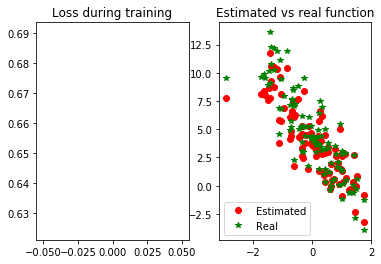

batch 199. Average loss: 0.000013


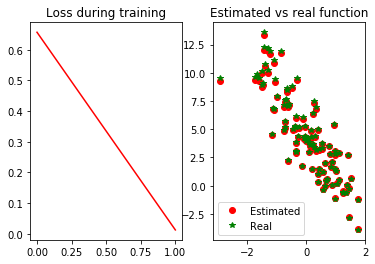

batch 299. Average loss: 0.000000


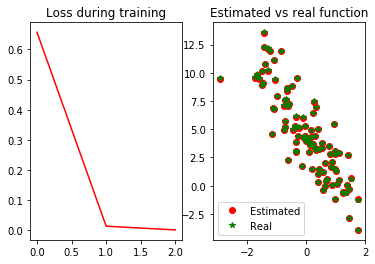

batch 399. Average loss: 0.000000


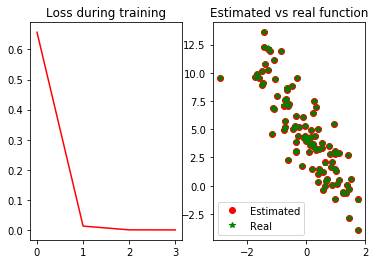

batch 499. Average loss: 0.000000


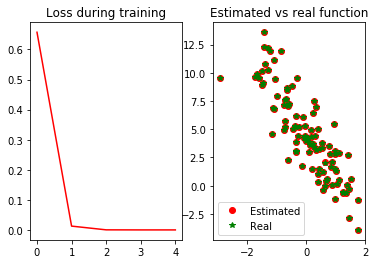

batch 599. Average loss: 0.000000


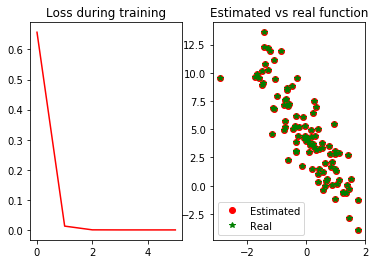

batch 699. Average loss: 0.000000


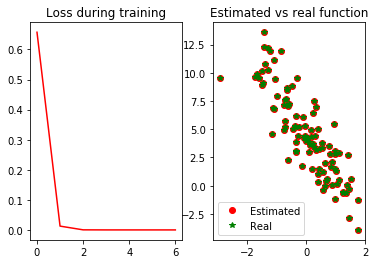

batch 799. Average loss: 0.000000


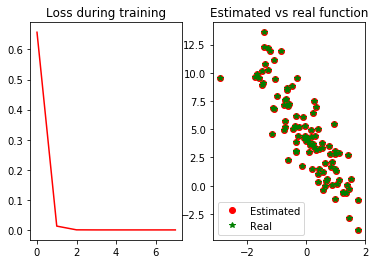

batch 899. Average loss: 0.000000


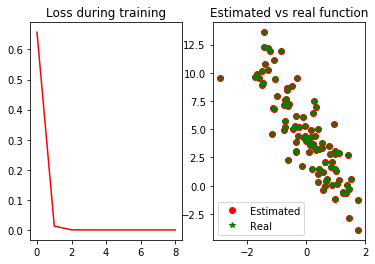

batch 999. Average loss: 0.000000


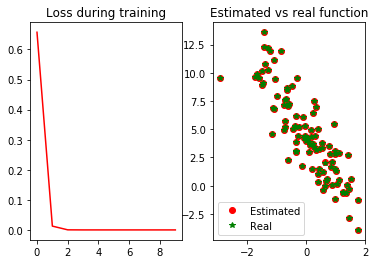

(array([[ 2.0003169],
       [-3.3998399]], dtype=float32), array([4.200424], dtype=float32))
(array([ 2. , -3.4]), 4.2)


In [9]:
learning_rate = 1e-2
num_epochs = 100
batch_size = 100
losses = []
input_placeholder = tf.placeholder(tf.float32, [None, num_inputs])
gt_placeholder = tf.placeholder(tf.float32, [None])
predict, weights, bias = net(input_placeholder, num_inputs, 1)
mse = loss(predict, gt_placeholder)
var_list = tf.trainable_variables()
for var in var_list:
    print var.op.name
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(mse)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

for i,  data in enumerate(data_iter(batch_size, num_epochs)):
    batch_X, batch_y = data
    feed_dict = {input_placeholder: batch_X, gt_placeholder: batch_y}
    mse_, _ = sess.run([mse, train_op], feed_dict=feed_dict)
    if (i + 1) % 100 == 0:
        predict_, mse_, weights_, bias_ = sess.run([predict, mse, weights, bias], feed_dict={input_placeholder: X, gt_placeholder: y})
        losses.append(mse_)
        print("batch %s. Average loss: %f" % (i, mse_/num_examples))
        plot(losses, X, np.array(predict_))
        

print (weights_, bias_)
print (true_w, true_b)